# Sessa Empirical Estimator

## Setup

### Import Libraries and Set Paths

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

### Setup sample data

In [154]:
# Sample data equivalent to med.events
data = {
  'pnr': np.random.randint(1, 100, 1000),
  'eksd': pd.date_range(start='1/1/2020', periods=1000, freq='D'),
  'perday': np.random.randint(1, 10, 1000),
  'ATC': np.random.choice(['medA', 'medB'], 1000),
  'dur_original': np.random.randint(1, 30, 1000)
}
example_pats = pd.DataFrame(data)

## Callable Functions

In [155]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd']).copy()  # Ensure a copy to prevent unintended modifications
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    # Ensure we work with a deep copy of the subset
    drug_see2 = arg1.dropna(subset=['prev_eksd']).copy()
    
    # Use .loc to avoid SettingWithCopyWarning
    drug_see2.loc[:, 'p_number'] = drug_see2.groupby('pnr').cumcount() + 1

    # Apply filtering with .loc to avoid unintended view modification
    drug_see2 = drug_see2.loc[drug_see2['p_number'] >= 2].copy()

    # Calculate duration
    drug_see2.loc[:, 'Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days

    # Compute median of medians
    medians_of_medians = drug_see2.groupby('pnr')['Duration'].median().median()

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=drug_see2)
    plt.axhline(medians_of_medians, linestyle='--', color='red')
    plt.show()


In [156]:
def see(arg1):
    # Filter dataset based on input argument
    c09ca01 = example_pats[example_pats['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()

    # Sort by 'pnr' and 'eksd', then compute previous event date
    drug_see_p1 = drug_see_p1.sort_values(by=['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)

    # Use assignment instead of inplace dropna
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])

    # Fix deprecated .apply() usage
    drug_see_p1 = drug_see_p1.sample(frac=1).groupby('pnr', group_keys=False).head(1).reset_index(drop=True)

    # Compute event interval in days (ensure it's an integer)
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(int)

    # Compute ECDF and determine threshold for 80th percentile
    ecdf = drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(drug_see_p1)
    dfper = ecdf[ecdf <= 0.8].reset_index()
    dfper.columns = ['x', 'y']
    ni = dfper['x'].max()

    # Filter dataset based on threshold
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni]

    # Estimate density using Gaussian KDE
    density = gaussian_kde(np.log(drug_see_p2['event_interval']))
    x_vals = np.linspace(np.log(drug_see_p2['event_interval']).min(), np.log(drug_see_p2['event_interval']).max(), 1000)
    y_vals = density(x_vals)
    a = pd.DataFrame({'x': x_vals, 'y': y_vals})
    a = StandardScaler().fit_transform(a)

    # Clustering using KMeans
    silhouette_avg = silhouette_score(a, KMeans(n_clusters=2, random_state=1234).fit_predict(a))
    cluster = KMeans(n_clusters=2, random_state=1234).fit(dfper[['x']])
    dfper['cluster'] = cluster.labels_

    # Compute cluster statistics explicitly using .agg()
    nif = dfper.groupby('cluster').agg(Minimum=('x', 'min'), Maximum=('x', 'max'), Median=('x', 'median')).reset_index()

    # Merge cluster information
    results = drug_see_p1.merge(nif, how='cross')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & (results['event_interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )

    # Use assignment instead of inplace dropna
    results = results.dropna(subset=['Final_cluster'])

    results['Median'] = np.exp(results['Median'])

    # Determine most common cluster
    t1 = results['cluster'].value_counts().idxmax()
    t1_merged = results[results['cluster'] == t1].iloc[0]

    # Merge with main dataset
    drug_see_p1 = drug_see_p1.merge(results[['pnr', 'Median', 'cluster']], on='pnr', how='left')

    # Fix inplace fillna usage
    drug_see_p1 = drug_see_p1.assign(
        Median=drug_see_p1['Median'].fillna(t1_merged['Median']),
        cluster=drug_see_p1['cluster'].fillna(0)
    )

    drug_see_p1['test'] = np.round(drug_see_p1['event_interval'] - drug_see_p1['Median'], 1)

    # Final merge
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'cluster']]
    drug_see_p0 = drug_see_p0.merge(drug_see_p3, on='pnr', how='left')

    # Fix inplace fillna usage
    drug_see_p0 = drug_see_p0.assign(
        Median=drug_see_p0['Median'].fillna(t1_merged['Median']),
        cluster=drug_see_p0['cluster'].fillna(0)
    )

    return drug_see_p0


## Execution

In [157]:
med_a = see("medA")
med_a

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,59,2020-01-02,7,medA,28,1.791140e+84,1.0
1,52,2020-01-04,9,medA,18,1.791140e+84,1.0
2,42,2020-01-05,9,medA,29,9.253782e+29,0.0
3,60,2020-01-06,9,medA,3,9.253782e+29,0.0
4,87,2020-01-09,9,medA,6,9.253782e+29,0.0
...,...,...,...,...,...,...,...
488,5,2022-09-18,6,medA,11,9.253782e+29,0.0
489,56,2022-09-20,9,medA,14,1.791140e+84,1.0
490,75,2022-09-21,8,medA,2,9.253782e+29,0.0
491,98,2022-09-23,5,medA,21,9.253782e+29,0.0


In [158]:
med_b = see("medB")
med_b

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,22,2020-01-01,9,medB,18,3.404276e+29,0.0
1,63,2020-01-03,9,medB,18,3.404276e+29,0.0
2,3,2020-01-07,6,medB,6,3.404276e+29,0.0
3,68,2020-01-08,5,medB,22,6.338619e+98,1.0
4,6,2020-01-10,9,medB,6,3.404276e+29,0.0
...,...,...,...,...,...,...,...
502,7,2022-09-17,2,medB,13,3.404276e+29,0.0
503,88,2022-09-19,2,medB,22,3.404276e+29,0.0
504,27,2022-09-22,9,medB,29,3.404276e+29,0.0
505,33,2022-09-24,5,medB,11,3.404276e+29,0.0


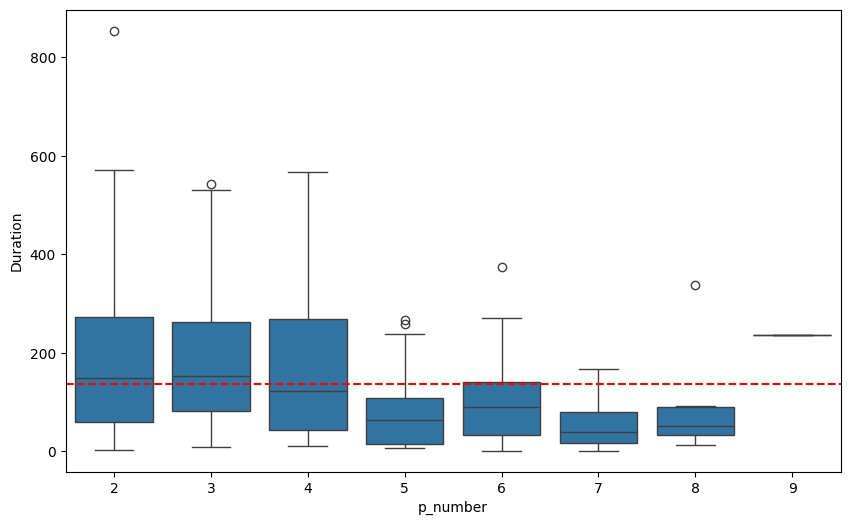

In [159]:
see_assumption(med_a)

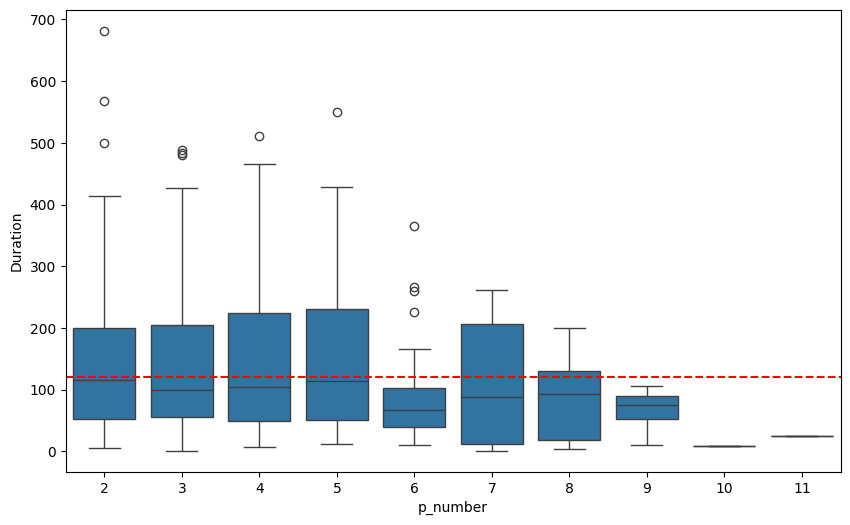

In [160]:
see_assumption(med_b)